## CSC420 Assignment 2
### Brendan Neal | 1001160236 | nealbre1

Imports and some helper functions

In [1]:
import numpy as np
from scipy import spatial
import cv2 as cv
import math

from matplotlib import pyplot as plot

# Make the plot a certain size
plot.rcParams["figure.figsize"] = [8, 6]

# Shows an image, and saves it if a filename is given
def display_image(img, file_name=None):
    
    flt_img = img.astype(float)
    img_max, img_min = np.max(flt_img), np.min(flt_img)
    
    norm_img = (((flt_img - img_min) / (img_max - img_min)) * 255).astype(np.uint8)
    
    if len(img.shape) == 2:
        plot.imshow(norm_img, cmap='gray')
    elif (len(img.shape) == 3):
        plot.imshow(cv.cvtColor(norm_img, cv.COLOR_BGR2RGB))
    plot.show()
    
    if file_name:
        cv.imwrite(file_name, norm_img)

def show_scatter_plot(inputs, function, x_label, y_label):
    """
    Displays the scatter-plot of repeatedly applying function to the elements of inputs.
    X axis = input
    Y axis = function(input)
    """
    inps = list(inputs)
    
    plot.scatter(inps, [function(x) for x in inps])
    plot.xlabel(x_label)
    plot.ylabel(y_label)
    
    plot.show()

#### Question 1a: Harris/Brown Corner Metric Implementation

In [2]:
def derivative(float_img, kernel_size, x_degree, y_degree):
    return cv.Sobel(
        float_img, cv.CV_64F, 
        x_degree, y_degree, 
        ksize=kernel_size
    )

def gauss_blur(float_img, sigma=1):
    return cv.GaussianBlur(
        float_img, 
        ksize=(0, 0),
        sigmaX=sigma, sigmaY=sigma
    )

def corner_components(float_img):
    
    blurred = gauss_blur(float_img)
    i_x = derivative(blurred, 5, 1, 0)
    i_y = derivative(blurred, 5, 0, 1)
    
    i_x2 = gauss_blur(i_x ** 2)
    i_y2 = gauss_blur(i_y ** 2)
    i_xy = gauss_blur(i_x * i_y)
    
    det = (i_x2 * i_y2) - (i_xy ** 2)
    trace = i_x2 + i_y2
    
    return det, trace

def harris_corners(float_img, k):
    assert (0.04 <= k <= 0.06)
    
    det, trace = corner_components(float_img)
    return det - (k * (trace ** 2))

def brown_corners(float_img):
    
    # Ignore division by 0 errors
    with np.errstate(divide='ignore', invalid='ignore'):
        
        det, trace = corner_components(float_img)
        divided = det / trace

        # Dividing by 0 produces NAN, so ignore these pixels by setting them to maximum
        return np.nan_to_num(divided, np.nanmax(divided))


Applying the above code to *building.jpg*

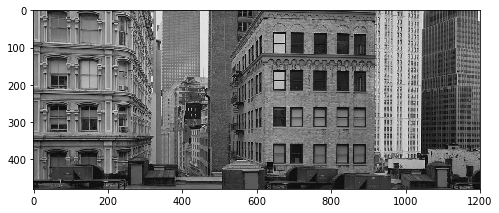

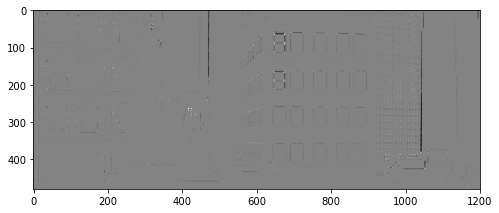

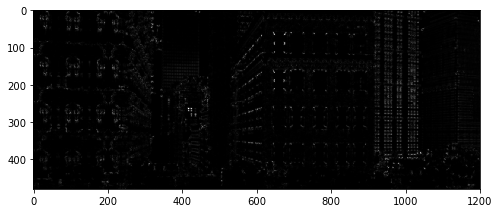

In [3]:
building = cv.imread("building.jpg", cv.IMREAD_GRAYSCALE).astype(np.float32)
display_image(building)

harris_building = harris_corners(building, 0.05)
display_image(harris_building, "q1A-harris-output.jpg")

brown_building = brown_corners(building)
display_image(brown_building, "q1A-brown-output.jpg")

The second and third images above are the Harris (R) and Brown (Harmonic Mean) corner metrics, respectively. 

They have been displayed in a normalized fashion (0 corresponds to original minimum pixel value, 255 to original maximum pixel value).

We can see that the Harris response metric produced an image with much higher variance than the Brown counterpart - most of the Harris response is gray. This is because the distribution of pixels in the Harris response seems to cover both positive and negative values, whereas the Brown response is mostly positive.

#### Question 1a: Non-Maximal Suppression

In [4]:
# Copied from A1
def patch_view(arr, patch_h, patch_w):
    """(numpy.array, int, int) -> numpy.array
    Creates a 4D, read-only view of some 2D numpy array as a 2D array of 2D patches.
    There are (arr_height x arr_width) patches and each patch is of size (patch_h, patch_w)

    :param arr: some 2D numpy array
    :param patch_h: desired height for patches
    :param patch_w: desired width for patches
    :return: 4D array of (patch_h x patch_w) patches
    """
    assert len(arr.shape) == 2

    # Numpy stride code examples (magic):
    # https://stackoverflow.com/questions/16774148/
    # https://github.com/keras-team/keras/issues/2983

    # New height and width are now going to be in terms of
    # number of overlapping patches we can fit into arr
    new_h, new_w = np.array(arr.shape) - np.array([patch_h, patch_w]) + 1

    return np.lib.stride_tricks.as_strided(
        np.ascontiguousarray(arr),
        shape=(new_h, new_w, patch_h, patch_w),
        strides=arr.strides + arr.strides,
        writeable=False
    )

def circular_mask(radius):
    """(int -> numpy.array)
    Creates a 2D-boolean mask of a circle with radius radius. 
    Returns a 2D, square array with side length size 2*radius + 1
    """
    
    diameter = 2*radius + 1
    
    center_x = center_y = radius
    x, y = np.indices((diameter, diameter))
    
    distances = ((center_x - x) ** 2 + (center_y - y) ** 2) ** 0.5
    return (distances <= radius)

def zero_padded(arr, thickness):
    return np.pad(
        arr, ((thickness, thickness), (thickness, thickness)),
        mode='constant', constant_values=0
    )
    

def non_maximal_suppression(float_img, radius, circle):
    
    # Radius should be odd 
    # (e.g. radius k -> patch of size (2k + 1)x(2k + 1))
    patch_size = (radius * 2) + 1
    
    # Pad the given image so the number of patches == number of pixels
    padding = patch_size // 2
    padded = zero_padded(float_img, padding)
    
    # 2D Array of 2D patches
    patches = patch_view(padded, patch_size, patch_size)
    
    # Create mask for suppression in neighbourhood
    # (when taking maximum of patch, ignore pixels outside the mask)
    mask = circular_mask(radius) if circle else np.ones((patch_size, patch_size))
    patch_maxes = np.empty(float_img.shape)
    patch_maxes[:, :] = np.amax(patches[:, :] * mask, axis=(2, 3))
    
    # Suppress pixels that are NOT the maximum within their patches
    ret = np.copy(float_img)
    ret[ret != patch_maxes] = 0
    
    return ret

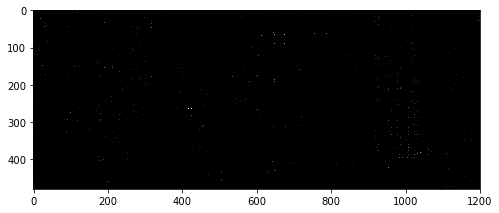

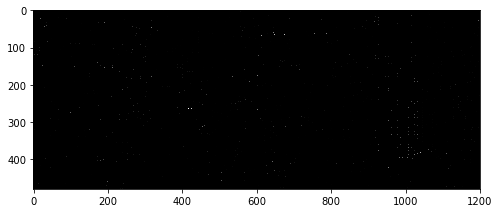

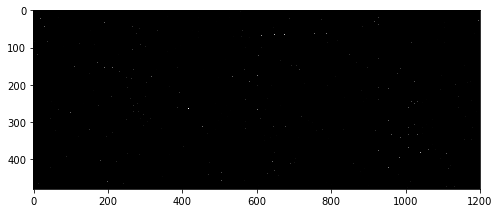

In [5]:
for radius in [2, 4, 8]:
    display_image(
        non_maximal_suppression(brown_building, radius, circle=True), 
        f"q1B-nonmax-suppression-output-r={radius}.jpg"
    )

Note: Please see the raw image files attached in the submission. The PDF doesn't seem to treat isolated pixels very nicely.

We can see that as r increases, the amount of detected details decreases. This difference can be seen clearly between the 2 and 8-radius images. Particular areas of interest where fine details are displayed much more apparently are:

Building on the left-hand side, in particular the decorative window frames

Corners of the windows belonging to the distant tower on the right

Corners of the window-frames on the center building

The granularity of the high-response regions is inversely proportional to the radius of non-maximal suppression. This is because a larger radius causes the algorithm to inspect a wider neighbourhood. Therefore, the chance that the center pixel is a maximum is much lower, so it has a higher chance of being suppressed. For pixels in the same neighbourhood, pixels that correspond to fine details are more likely to be suppressed as they will have smaller response values.

#### Question 1c: Blob Detection via Laplacian

In [6]:
def gauss_pyramid(float_img, sigma = 1.6):
    """
    Yields a sequence of tuples of the following form:
    
    (img, scale)
        img : i-th halving of float_img
        scale : 2 ** i
    """
    
    # Figure out how many times the image can be halved
    shortest_side = min(float_img.shape)
    num_reductions = int(np.log2(shortest_side)) - 1
    
    cur_image = float_img
    for i in range(num_reductions):
        
        scale = 2 ** i
        yield cur_image, scale
        
        # Move onto a blurred and halved version of the image
        cur_image = cv.pyrDown(cur_image)

def gauss_octave(float_img, length, sigma = 1.6):
    """
    Yields a sequence of length-many tuples of the following form:
    
    (img, blur_width)
        img: i-th gaussian blurring of float_img
        blur_width: sigma of the gaussian blur
    """
    scaling_factor = 2 ** (1 / length)
    
    for i in range(length):
        blur_width = sigma * (scaling_factor ** i)        
        yield gauss_blur(float_img, blur_width), blur_width
        
def laplace_octave(float_img, octave_length, sigma = 1.6):
    """
    Yields a sequence of length-many tuples of the following form:
    
    (img, blur_width)
        img: absolute laplacian of the i-th gaussian blurring of float_img
        blur_width: sigma of the gaussian blur
    """
    for img, blur_width in gauss_octave(float_img, octave_length, sigma):
        laplace = np.abs(cv.Laplacian(img, ddepth=cv.CV_32F, ksize=5, scale=1))
        yield laplace, blur_width       

def laplace_maxima_suppression(cur_img, neighbours):
    """
    Suppresses points (sets to 0) iff they are NOT maxima across:
        Their surrounding 3x3 patch
        The corresponding 3x3 patches in neighbours
    """
    # 0-Padding of thickness 1 for each image
    cur_pad = zero_padded(cur_img, 1)
    neighs_padded = [zero_padded(x, 1) for x in neighbours]
    
    # 3x3 patch views of each image
    cur_patches = patch_view(cur_pad, 3, 3)
    neigh_patches = [patch_view(x, 3, 3) for x in neighs_padded]
    
    # Max of each patch, then across all patches
    cur_max = np.amax(cur_patches, axis=(2, 3))
    neigh_maxes = [np.amax(x, axis=(2, 3)) for x in neigh_patches]
    all_max = np.amax(np.dstack([cur_max] + neigh_maxes), axis=2)
    
    # True iff pixel of cur_img is a maximum across 
    # local neighbourhood and neighbouring neighbourhoods
    is_cur_max = np.equal(cur_img, all_max)
    
    # Suppress the pixels that don't count
    return cur_img * is_cur_max

def laplace_octave_suppression(octave):
    """
    Performs laplace_maxima_suppression over the following groups of images in octave:
    (first, [second])
    (intermediate, [intermediate - 1, intermediate + 1])
    (penultimate, [last])
    
    Returns a list of the results.
    """
    
    # Check first against second
    ret = [
        laplace_maxima_suppression(octave[0], [octave[1]])
    ]
    
    # Check middle sections against up and down neighbours
    for i in range(len(octave) - 2):
        (down, cur, up) = octave[i:i+3]        
        ret += [laplace_maxima_suppression(cur, [down, up])]
    
    # Check last against second last
    ret += [laplace_maxima_suppression(octave[-1], [octave[-2]])]
    
    return ret
    
        
def laplace_octave_maxima(float_img, octave_length, sigma = 1.6):
    """
    Return the responses, coordinates and blur widths of the pixels 
    that are local maxima within octave/scale.
    Returns a numpy array of form [[response, y, x, blur width]]
    """
    
    # Store and unpack the laplace octave
    tups = list(laplace_octave(float_img, octave_length, sigma))
    laplaces = [x[0] for x in tups]
    blur_widths = np.array([x[1] for x in tups])
    
    # Suppress the maxima of the octave
    suppressed = laplace_octave_suppression(laplaces)
    
    # For each vector which index has the highest response?
    stacked = np.dstack(suppressed)
    max_response_ind = np.argmax(stacked, axis=2)
    
    # Determine maximum response and corresponding blur widths
    max_responses = np.amax(stacked, axis=2)
    pixel_blur_widths = blur_widths[max_response_ind]
    
    # Get the blur width and response of each maxima
    maxima_coords = np.nonzero(max_responses)
    blurs_of_maxima = pixel_blur_widths[maxima_coords]
    responses = max_responses[maxima_coords]

    # Merge the arrays together
    return np.array([responses, *maxima_coords, blurs_of_maxima]).transpose()

def laplace_maxima(float_img, octave_length, sigma = 1.6):
    """
    Return the responses, SCALED coordinates and blur widths of the pixels 
    that are maxima across all octaves.
    
    Returns a numpy array of form [[response, y, x, blur width]]
    """
    
    arrays = []
    for img, scale in gauss_pyramid(float_img, sigma):
        oct_max = laplace_octave_maxima(img, octave_length, sigma)
        oct_max[:, 1:] *= scale
        arrays += [oct_max]
        
    return np.concatenate(arrays)

def show_laplace_interest_pts(float_img, octave_length, sigma = 1.6, percentile = 80):
    
    # Create color channel image
    ret = np.dstack([np.copy(float_img)] * 3)
    
    maxima = laplace_maxima(float_img, octave_length, sigma)
    
    threshold = np.percentile(maxima[:, 0], percentile)
    for (response, y, x, blur_width) in maxima:
        if response > threshold:
            radius = blur_width * (2 ** 0.5)
            cv.circle(ret, (int(x), int(y)), int(radius), (0, 255, 0), 2)
        
    return ret
    


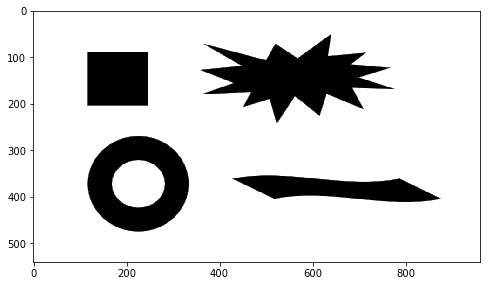

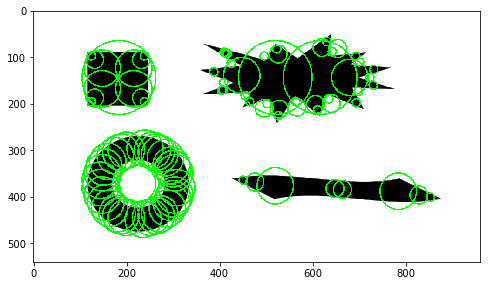

In [7]:
synthetic = cv.imread("synthetic.png", cv.IMREAD_GRAYSCALE).astype(np.float32)
display_image(synthetic)

# Run algorithm, show interest points with 97th percentile response or higher
synth_interest_pts = show_laplace_interest_pts(
    synthetic,
    octave_length = 5,
    sigma = 7,
    percentile = 97
)
display_image(synth_interest_pts, "q1c-output.jpg")

#### Question 1d: Other Feature Detector (SURF)

More info:
https://en.wikipedia.org/wiki/Speeded_up_robust_features

SURF stands for "Speeded Up Robust Features". 

SURF follows the same high-level steps as SIFT. However, the implementation of some steps is different. Most of the changes are made so that SURF performs much faster than SIFT. 

Some differences in implementation (arranged by high-level step):

* **Scale Invariant Feature Detection**: find image interest points across many scales (reduce the search space for matching images)
    * SIFT: Use Difference-of-Gaussians across an image pyramid to approximate Laplacian. Extrema are interest points.
    * SURF: Use determinants of Hessian Matrices across increasing blur-filter sizes to determine extrema 
        * Speedup 1: use a box-filter (simple sum) instead of Gaussian filter
        * Speedup 2: box-filter computation can be sped up using integral of image (sums of patches)  
        
        
* **Interest Point Orientation**: determine orientation of interest points (for rotational invariance)
    * SIFT: Use arc-tangent, gradients of gaussians and neighbourhood historgrams
    * SURF: Use Haar wavelet responses in interest point neighbourhoods


* **Descriptor Generation**: encode  enough information about an interest point into a high-dimensional vector such that distance metrics can be used for robust matching
    * SIFT: Use histograms of gradients (oriented relative to a dominant gradient direction) to compute the vector
    * SURF: Use Gaussian weighting instead of histogram, and smaller/less neighbourhoods to produce lower-dimensional vector

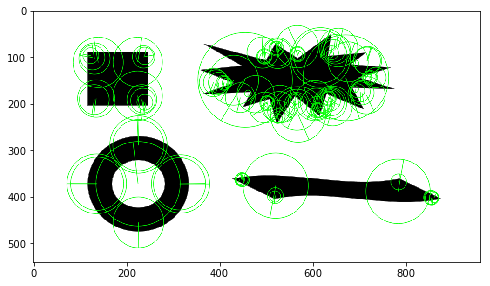

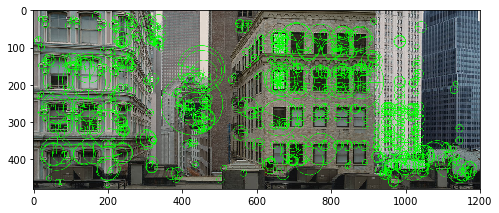

In [8]:
def draw_surf_keypoints(img, hessian_threshold):
    
    surf = cv.xfeatures2d.SURF_create(hessian_threshold)
    keypoints, descriptors = surf.detectAndCompute(img, None)
    ret = cv.drawKeypoints(img, keypoints, None, (0, 255, 0),  4)
    
    return ret

building_color = cv.imread("building.jpg")
synth_color = cv.imread("synthetic.png")

# Picking fairly high Haar thresholds to limit number of keypoints drawn
surf_synth = draw_surf_keypoints(synth_color, 15000)
display_image(surf_synth, "q1d-surf-synth-output.jpg")

surf_building = draw_surf_keypoints(building_color, 3000)
display_image(surf_building, "q1d-surf-building-output.jpg")

#### Question 2: SIFT Matching

Note: I'm going to be using the SIFT feature extractor provided with opencv_contrib.

#### Question 2a: SIFT Keypoint / Feature Extraction

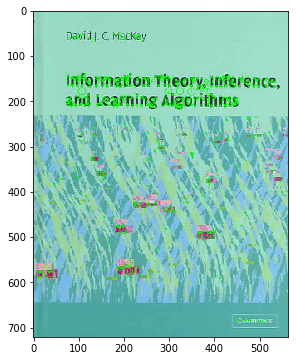

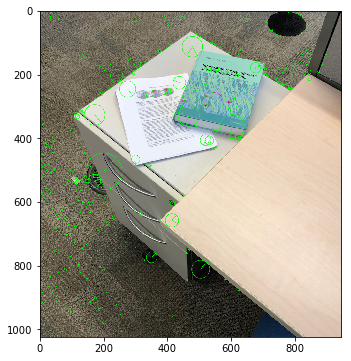

In [9]:
def extract_sift_data(img):
    sift = cv.xfeatures2d.SIFT_create(1000)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors

def draw_sift_keypoints(img, keypoints):
    return cv.drawKeypoints(img, keypoints, None, (0, 255, 0),  4)

book = cv.imread("book.jpeg")
book_kp, book_desc = extract_sift_data(book)
display_image(draw_sift_keypoints(book, book_kp), "q2a-book-output.jpg")

find_book = cv.imread("findBook.png")
find_book_kp, find_book_desc = extract_sift_data(find_book)
display_image(draw_sift_keypoints(find_book, find_book_kp), "q2a-find-book-output.jpg")

#### Question 2b: Matching SIFT Keypoints

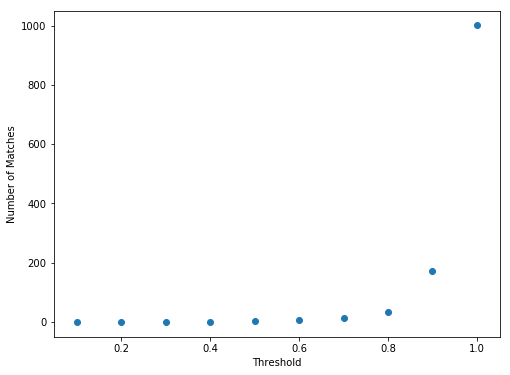

In [10]:
def match_sift_descriptors(left, right, threshold):
    """
    Returns a 2D array of form [[i, j, distance]], where
        i - index of a vector in left
        j - index of the closest matching vector in right
        distance - integer distance between vectors i, j
    Results are sorted by the distance of the vector pairs.
    """
    
    # Return empty if either left or right is empty
    left_empty = (left is None) or (len(left) == 0)
    right_empty = (right is None) or (len(right) == 0)
    if left_empty or right_empty:
        return np.empty((0, 3)).astype(int)
    
    # [i, j]-th is euclidean distance between left[i], right[j]
    euc_dists = spatial.distance.cdist(left, right, 'euclidean')
    
    # [i, j]-th is the index of the j-th closest right-vector to left[i]
    sort_inds = np.argsort(euc_dists, axis=1)
    
    # top 2 matches are represented by first and second columns of above
    closest, closest2 = sort_inds[:, 0], sort_inds[:, 1]
    
    # Compute distance ratios between (left, first closest right) vs. (left, second closest left)
    left_inds = np.arange(left.shape[0])
    dist_ratios = euc_dists[left_inds, closest] / euc_dists[left_inds, closest2]
    
    # Suppress where distance ratio is above some threshold
    suppressed = dist_ratios * (dist_ratios < threshold)
    
    # Get indices where suppression didn't happen
    left_inds = np.nonzero(suppressed)[0]
    right_inds = closest[left_inds]
    
    # Pair the above indices together, determine distance of pair
    pairs = np.stack((left_inds, right_inds)).transpose()
    pair_dists = euc_dists[pairs[:, 0], pairs[:, 1]]
    
    sorted_dist_inds = np.argsort(pair_dists)
    sorted_pairs = pairs[sorted_dist_inds]
    sorted_dists = pair_dists[sorted_dist_inds].reshape((sorted_pairs.shape[0], 1))
    
    return np.hstack((sorted_pairs, sorted_dists)).astype(int)

# Note: instructions are very unclear, so I'm plotting the number of matches overall
# https://q.utoronto.ca/courses/51548/discussion_topics/113030
show_scatter_plot(
    (x / 10 for x in range(1, 11)), 
    lambda x : match_sift_descriptors(book_desc, find_book_desc, x).shape[0],
    "Threshold", 
    "Number of Matches"
)

*Note: the instructions are unclear as to what threshold qualifies as the "best"*

The best ratio seems to be around 0.8 (this is what SIFT uses). 

A threshold of 0.8 seems to be an inflection point in the number of generated matches. 

Beyond 0.8 it's likely that a lot of bad matches will start appearing - the second-closest descriptor is not far enough away from the "pivot" descriptor for the closest descriptor to be considered the "closest" (after accounting for noise). 

Intuition - if the top two players scored within 20% of each other in a noisy (performance-wise) contest, we can't really be sure whether the first player is actually better.

#### Question 2c / Question 2d: Solving for Affine Transformation & Visualization

The minimum $k$ needed to solve the affine transformation is 3. 

Recall equation from lecture 8B: 
$$P_{2k\times6} A_{6\times1} = P'_{2k\times1} \implies A = P^{-1}P'$$ 

In order for $P$ to be invertible, it must be square.
$$P_{m \times m} = P_{2k\times6} \implies m=2k=6 \implies 2k=6 \implies k=3$$

Also note that the pseudo-inverse of $P$ only yields a proper solution when 
$$2k > 6 \implies k > 3$$


Affine matrix and transform visualization using top 3 matches:
[[ 3.59023418e-01 -8.54986764e-02  4.97330632e+02]
 [ 3.49024830e-02  5.06672928e-01  9.47132379e+01]]


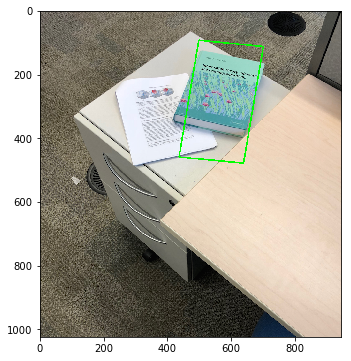


Affine matrix and transform visualization using top 5 matches:
[[ 3.59957424e-01 -9.16555062e-02  4.98136806e+02]
 [ 7.29655948e-02  2.55766653e-01  1.27566843e+02]]


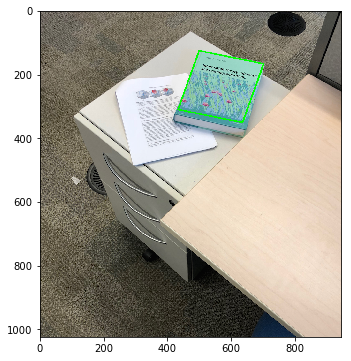


Affine matrix and transform visualization using top 7 matches:
[[ 3.61562644e-01 -9.80558688e-02  4.99130059e+02]
 [ 7.26878951e-02  2.72926279e-01  1.24651135e+02]]


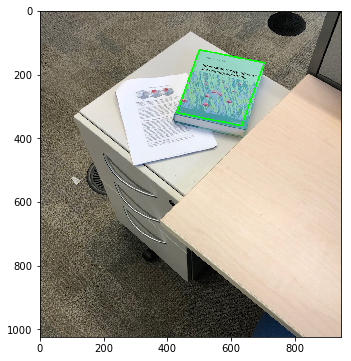


Affine matrix and transform visualization using top 9 matches:
[[ 3.78823523e-01 -9.35781678e-02  4.94851394e+02]
 [ 1.12131446e-01  2.84207048e-01  1.14627894e+02]]


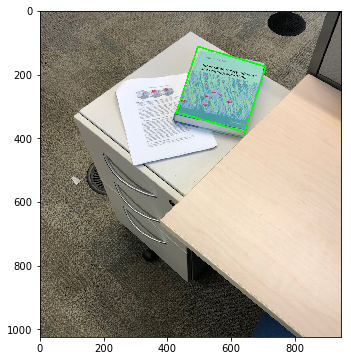

In [11]:
# Left : Source, Right : Target

def keypoints_to_coords(keypoints):
    """
    Converts keypoints into a numpy array of form [[x, y]]
    """
    return np.array([kp.pt for kp in keypoints])

def affine_left_matrix(coords):
    """
    Input: array of form [[x, y]]
    Returns a 2D array of form
    [
        ...
        [x, y, 0, 0, 1, 0]
        [0, 0, x, y, 0, 1]
        ...
    ]
    """
    
    # Need to have 6 columns, and twice as many rows
    ret_dims = (coords.shape[0] * 2, 6)
    ret = np.empty(ret_dims, coords.dtype)
    
    # Use numpy indexing
    i = np.arange(coords.shape[0])
    
    # Even Rows: [x, y, 0, 0, 1, 0]
    ret[2*i, :2] = coords[i]
    ret[2*i, 2:] = [0, 0, 1, 0]
    
    # Odd Rows: [0, 0, x, y, 0, 1]
    ret[2*i + 1, :2] = [0, 0]
    ret[2*i + 1, 2:4] = coords[i]
    ret[2*i + 1, 4:] = [0, 1]
    
    return ret

def affine_right_matrix(coords):
    """
    Returns a 2D array of form 
    [
        [x]
        [y]
        ...
    ]
    """
    
    # Return array needs to be twice as long
    ret = np.empty(coords.shape[0] * 2, dtype = coords.dtype)
    
    # Use numpy indexing
    i = np.arange(coords.shape[0])
    
    # Even Rows = x
    ret[2*i] = coords[i, 0]
    
    # Odd Rows = y 
    ret[2*i + 1] = coords[i, 1]
    
    return ret
    
    
def solve_affine_transform(left_kp_coords, right_kp_coords, k):
    
    assert k >= 3
    
    top_left, top_right = left_kp_coords[:k], right_kp_coords[:k]
    assert top_left.shape == top_right.shape
    
    # Using equation from lecture 8B: PA = P' -> A = P_inv * P'
    P = affine_left_matrix(top_left)
    P_prime = affine_right_matrix(top_right)
    
    # Compute inverse using moore-penrose pseudo inverse
    P_inv = np.linalg.pinv(P)
    
    # Approximation of affine transformation vector (a, b, c, d, e, f)
    (a, b, c, d, e, f) = np.matmul(P_inv, P_prime).flatten()
    
    # The affine transformation matrix
    return np.array(
        [[a, b, e],
         [c, d, f]]
    )

def affine_transform(coords, transform_matrix):
    """
    Computes the affine transform of coords (form [[x, y]]) with transform_matrix.
    """
    
    # Add ones onto the end of every row, then transpose the matrix (columns are [x, y, 1])
    num_pts, num_dims = coords.shape
    with_ones = np.ones((num_pts, num_dims + 1))
    with_ones[:, :-1] = coords
    with_ones = with_ones.transpose()
    
    # Array of form [[x...], [y...]]
    transformed = np.matmul(transform_matrix, with_ones)
    
    return transformed.transpose()

def draw_polygon(img, polygon_clockwise, color, thickness):
    """
    Draws the polygon whose corner points are specified in clockwise order 
    in polygon_clockwise (array of form [[x, y]]) 
    onto a copy of img.
    """
    ret = np.copy(img)
    
    num_corners = polygon_clockwise.shape[0]
    for i in range(num_corners):
        
        # Figure out which points to connect together
        left_ind,  right_ind = (i % num_corners), ((i + 1) % num_corners)
        left, right = polygon_clockwise[left_ind], polygon_clockwise[right_ind]
        
        # Draw a line between them (cv needs int tuples)
        left_tup, right_tup = tuple(left.astype(int)), tuple(right.astype(int))
        cv.line(ret, left_tup, right_tup, color, thickness)
        
    return ret

def visualize_affine_transform(polygon_clockwise, img, transform_matrix):
    """
    Visualizes the affine transformation of transform_matrix by drawing a 
    quadrilateral (corner points specified by quadr, an array of form [[x, y]], clockwise order) 
    onto a copy of right_img.
    """
    
    # Transform the given polygon's corner points into new space
    new_poly = affine_transform(polygon_clockwise, transform_matrix)
    
    # Return the polygon drawn on the image
    return draw_polygon(img, new_poly, (0, 255, 0), 3)

sift_matches = match_sift_descriptors(book_desc, find_book_desc,  0.8)
book_kp_coords = keypoints_to_coords(book_kp)[sift_matches[:, 0]]
find_book_kp_coords = keypoints_to_coords(find_book_kp)[sift_matches[:, 1]]

# Determine four corners of the book (clockwise order)
book_h, book_w = book.shape[:2]
book_quadr = np.array([
    [0, 0], [book_w, 0],
    [book_w, book_h], [0, book_h]
])


for k in range(3, 10, 2):
    
    print("Affine matrix and transform visualization using top {} matches:".format(k))
    
    matrix = solve_affine_transform(book_kp_coords, find_book_kp_coords, k)
    print(matrix)
    
    visualized = visualize_affine_transform(book_quadr, find_book, matrix)
    display_image(visualized, "q2d-output-top-k={}.jpg".format(k))
    
    print("")

#### Question 2e : Color SIFT Matching

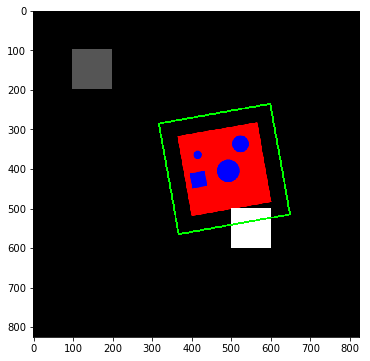

In [12]:
def gray_to_color(gray_img, num_colors):
    assert len(gray_img.shape) == 2
    return np.dstack([gray_img] * num_colors)

def visualize_sift_color_matches(left_img, right_img, threshold, k):
    """
    
    Algorithm (assume number of color channels identical)
    
        1) Acquire SIFT keypoints and descriptors across each color channel 
        
        2) Match SIFT descriptors WITHIN color channels
            Produce an array of form [[i, j, dist, channel]], where
                i - index of the keypoint/descriptor in left_img
                j - index of the keypoint/descriptor in right_img
                dist - euclidean distance between i,j descriptors
                channel - color channel the match occurred in
                
        3) Merge the matches (across all channels) together, sort by distance and 
        take top k matches (lowest distance)
        
        4) Use the tagged matches' keypoint coordinates 
        in the affine transformation calculation
        
    Reasoning / Intuition: if a match is "strong" enough to make it 
    into the top-k, across all color channels, it's probably a match
    """
    
    # Images should have same shape and number of color channels
    assert [len(left_img.shape), len(right_img.shape)] == [3, 3]
    assert left_img.shape[-1] == right_img.shape[-1]
    
    # Grab number of colors (should be last element of shape)
    num_colors = left_img.shape[-1]
    
    # OpenCV's SIFT only works on color images for some reason, so 
    # replicate each color channel 3 times to make it pseudo-RGB
    left_channels = (gray_to_color(left_img[..., i], num_colors) for i in range(num_colors))
    right_channels = (gray_to_color(right_img[..., i], num_colors) for i in range(num_colors))
    
    # Find keypoints and descriptors for left and right images
    left_kps, left_descs = zip(*(extract_sift_data(channel) for channel in left_channels))
    right_kps, right_descs = zip(*(extract_sift_data(channel) for channel in right_channels))
    
    # Get matches within each channel, then tag with color channel number in last column
    channel_matches = (
        match_sift_descriptors(left_descs[i], right_descs[i], threshold) 
            for i in range(num_colors)
    )
    tagged_matches = (
        np.hstack((matches, color * np.ones((matches.shape[0], 1)))).astype(int)
            for (color, matches) in enumerate(channel_matches)
    )
    
    # Merge matches together, sort by distance (3rd element), then take top k
    merged_matches = np.vstack([x for x in tagged_matches])
    sorted_matches = merged_matches[np.argsort(merged_matches[:, 2])]
    top_k_matches = sorted_matches[:k]
    
    # Grab the points associated with each match
    left_match_kp, right_match_kp = [], []
    for (i, j, dist, channel) in top_k_matches:
        left_match_kp += [left_kps[channel][i]]
        right_match_kp += [right_kps[channel][j]]
    
    # Convert keypoints into coordinates, then compute affine matrix
    left_match_kp_coords = keypoints_to_coords(left_match_kp)
    right_match_kp_coords = keypoints_to_coords(right_match_kp)
    affine_matrix = solve_affine_transform(left_match_kp_coords, right_match_kp_coords, k)
    
    # Determine four corners of the left (clockwise order)
    left_h, left_w = left_img.shape[:2]
    left_quadr = np.array([
        [0, 0], [left_w, 0],
        [left_w, left_h], [0, left_h]
    ])
    
    # Visualize the affine transformation
    return visualize_affine_transform(left_quadr, right_img, affine_matrix)

color_template = cv.imread("colourTemplate.png")
color_search = cv.imread("colourSearch.png")
display_image(visualize_sift_color_matches(color_template, color_search, 0.8, 7), "q2e-output.jpg")

#### Question 3: RANSAC

Recall: the minimum number of trials $S$ needed in order for RANSAC to produce a fitting model is

$$S(P, p, k) =\frac{log(1-P)}{log(1-p^k)}$$

Where:

$P$ is the probability that the trials produce a fitting model

$p$ is the proportion of inliers (number of inliers / number of points)

$k$ is the number of points used to fit the model

In [13]:
def S(P, p, k):
    return math.log(1 - P) / math.log(1 - (p ** k))

#### Question 3a: Plotting $k$ vs. $P(0.99, 0.7, k), k\in\{1...20\}$ 

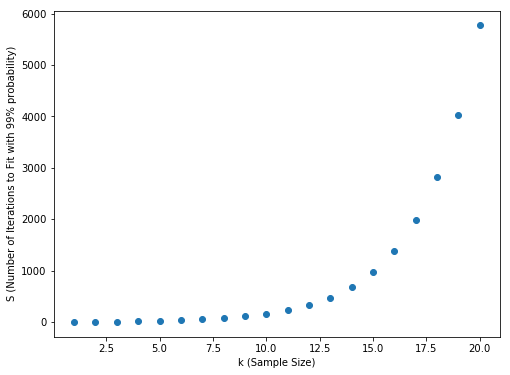

In [14]:
show_scatter_plot(
    range(1, 21), lambda k : S(0.99, 0.7, k), 
    "k (Sample Size)", 
    "S (Number of Iterations to Fit with 99% probability)"
)

#### Question 3a: Plotting $p$ vs. $P(0.99, p, 5), p\in[0.1, 0.5]$ 

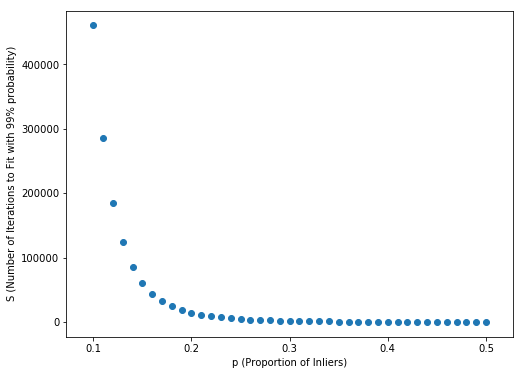

In [15]:
show_scatter_plot(
    (x / 100 for x in range(10, 51)), lambda p : S(0.99, p, 5),
    "p (Proportion of Inliers)", 
    "S (Number of Iterations to Fit with 99% probability)"
)

#### Question 3c: RANSAC Analysis

The required number of iterations is 14389 (14388.85, but we need to do one more iteration to achieve the minimum):

$$S(P, p, k) =\frac{log(1-P)}{log(1-p^k)}$$

$$P = 0.99, p = 0.2, k = 5 $$ 

$$S(0.99, 0.2, 5) =\frac{log(1-0.99)}{log(1-0.2^5)} $$

$$S(P, p, k)= \frac{-2}{log(1-0.00032)} $$

$$S(P, p, k)= \frac{-2}{log(0.99968)} $$

$$S(P, p, k)= \frac{-2}{-0.00013899647} $$

$$ S(P, p, k)= 14388.85 $$

The number of required iterations would *NOT* change. 

RANSAC will repeatedly propose and evaluate models for a set number of iterations, and then choose the best matching model out of all iterations. The algorithm won't stop early if it proposes a good model early on - it just keeps going to verify if that model is the best.

The required number of iterations is dependent on a **prior** estimate of inlier probability. This is a hyper-parameter of the model and is chosen before runtime. The estimate may not align with the actual number of inliers for any given set of points. For the example given in this question, $p=0.2$ might be a little pessimistic, given that the model proposed after just a few iterations had an inlier proportion of almost 1/3.  